In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile
local_zip = "/content/drive/MyDrive/Colab Notebooks/shoe_classifier.zip"
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [3]:
file_path = '/tmp/train/adidas/100.jpg'

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import matplotlib.image as mpimg

img = mpimg.imread(file_path)

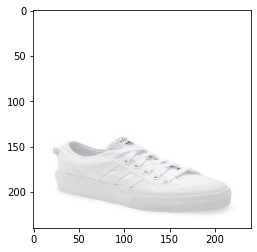

In [6]:
plt.imshow(img)

In [7]:
type(img)

numpy.ndarray

In [8]:
rot_img = tf.image.rot90(img)

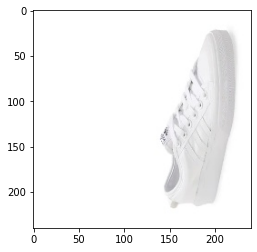

In [9]:
plt.imshow(rot_img)

In [10]:
img_shift = tf.image.flip_left_right(img)
img_shift2 = tf.image.flip_up_down(img)

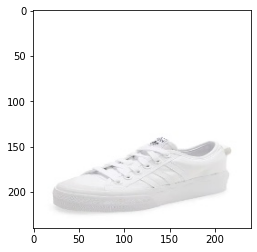

In [11]:
plt.imshow(img_shift)

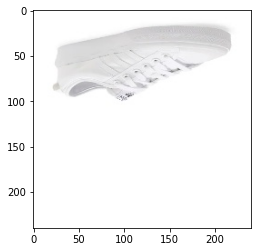

In [12]:
plt.imshow(img_shift2)

In [13]:
scales = list(np.arange(0.8,1.0,0.01))
print(scales)

[0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.8400000000000001, 0.8500000000000001, 0.8600000000000001, 0.8700000000000001, 0.8800000000000001, 0.8900000000000001, 0.9000000000000001, 0.9100000000000001, 0.9200000000000002, 0.9300000000000002, 0.9400000000000002, 0.9500000000000002, 0.9600000000000002, 0.9700000000000002, 0.9800000000000002, 0.9900000000000002]


In [14]:
boxes = np.zeros((len(scales), 4))
print(boxes)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [15]:
for i, scale in enumerate(scales):
  x1 = y1 = 0.5 - (0.5 * scale)
  x2 = y2 = 0.5 + (0.5 * scale)
  boxes[i] = [x1, y1, x2, y2]

def random_crop(img):
  # Create different crops for an image
  crops = tf.image.crop_and_resize([img], boxes=boxes, box_ind=np.zeros(len(scales)), crop_size=(32, 32))
  # Return a random crop
  return crops[tf.random_uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

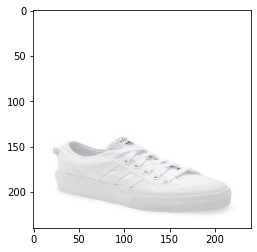

In [16]:
plt.imshow(img)

In [17]:
import os
print(len(os.listdir("/tmp/train/adidas")))

237


In [18]:
print(len(os.listdir("/tmp/train/converse")))

237


In [19]:
print(len(os.listdir("/tmp/train/nike")))

237


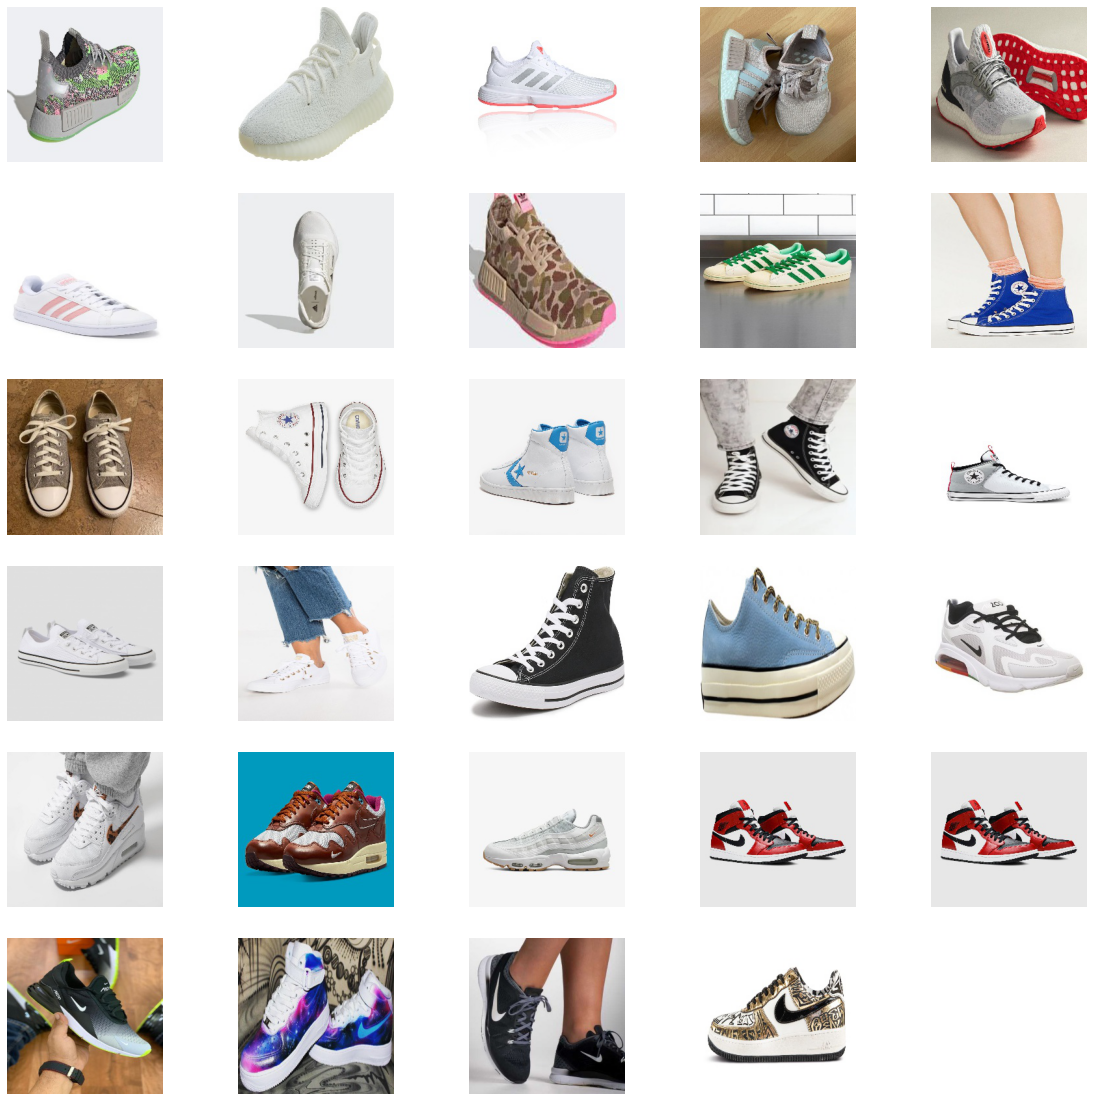

In [20]:
import random
labels = ["adidas", "converse", "nike"]

to_display = []

for label in labels:
  files = os.listdir("/tmp/train/" + label)
  for i in range(0,10):
    file_path = random.choice(files)
    img = mpimg.imread("/tmp/train/" + label + "/" + file_path)
    to_display.append(img)

fig = plt.figure(figsize = (20,20))
rows = 6
cols = 5
for i in range(1, len(to_display)):
  fig.add_subplot(rows, cols, i)
  plt.imshow(to_display[i])
  plt.axis("off")

In [21]:
len(os.listdir("/tmp/test/nike"))

38

In [22]:
len(os.listdir("/tmp/train/nike"))

237

In [23]:
img.shape

(240, 240, 3)

In [24]:
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0, 
                                                                rotation_range = 20, validation_split = 0.1, 
                                                                horizontal_flip = True, vertical_flip= True, 
                                                                width_shift_range = 0.2, 
                                                                height_shift_range= 0.2)
train_gen = train_datagen.flow_from_directory("/tmp/train/",
                                              batch_size = 32,
                                              class_mode='categorical',
                                              target_size = (250,250))

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0 / 255.0)
test_gen = test_datagen.flow_from_directory("/tmp/test/",
                                              batch_size = 32,
                                              class_mode='categorical',
                                              target_size = (250,250))

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [25]:
print(train_gen.n // 32)
print(test_gen.n // 32)

22
3


In [26]:
base_model = tf.keras.applications.ResNet50V2(include_top= False, weights = 'imagenet', input_shape = (240, 240, 3))

base_model.trainable = False

x = base_model.output

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024) (x)

x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs = base_model.input, outputs = x)

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-4, momentum = 0.9), loss = "categorical_crossentropy", metrics = ['accuracy'])


In [27]:
earlyStopping = tf.keras.callbacks.EarlyStopping(min_delta = 0.1, patience = 3, verbose = 1)

In [28]:
history = model.fit(train_gen, epochs = 20, steps_per_epoch = 22, validation_data= test_gen, validation_steps = 3, callbacks = [earlyStopping])

Epoch 1/20
22/22 [==============================] - 24s 555ms/step - loss: 1.5094 - accuracy: 0.3211 - val_loss: 1.2934 - val_accuracy: 0.3958
Epoch 2/20
22/22 [==============================] - 10s 467ms/step - loss: 1.3040 - accuracy: 0.3873 - val_loss: 1.1207 - val_accuracy: 0.4583
Epoch 3/20
22/22 [==============================] - 10s 464ms/step - loss: 1.1399 - accuracy: 0.4566 - val_loss: 0.9898 - val_accuracy: 0.5417
Epoch 4/20
22/22 [==============================] - 10s 466ms/step - loss: 1.0524 - accuracy: 0.5037 - val_loss: 0.9509 - val_accuracy: 0.5312
Epoch 5/20
22/22 [==============================] - 10s 471ms/step - loss: 0.9431 - accuracy: 0.5567 - val_loss: 0.9164 - val_accuracy: 0.5312
Epoch 6/20
22/22 [==============================] - 10s 466ms/step - loss: 0.8879 - accuracy: 0.5994 - val_loss: 0.8174 - val_accuracy: 0.6354
Epoch 7/20
22/22 [==============================] - 10s 467ms/step - loss: 0.8865 - accuracy: 0.6141 - val_loss: 0.8263 - val_accuracy: 0.5938